In [1]:
import numpy as np

from simulation import *
from scipy import signal
import seaborn as sns
import os
import pandas as pd

In [8]:


# Configuration start

# OBJECT
# file = './test_obj/remeshed2mm.obj'
# file = './test_obj/sample.obj'
# file = './test_obj/box.obj'
file = './test_obj/sphere.obj'
# file = './test_obj/4balls.obj'
# file = './test_obj/2balls.obj'
# file = './test_obj/BowlingPins1.obj'
# file = './test_obj/Tree2.obj'
# file = './test_obj/Palm.obj'
object_name = os.path.splitext(os.path.basename(file))[0]
# TODO: create dir if not exsist for  the test
# TODO: write all the spec in file and save it on the folder

# Recivers Setting
reciver_to_landscape = 8  # ditance to the landscape
azimut = 0  # head direction (depend on bats)
elevation_angle = 90  # target angle to the center point = 180 - elevation_angle
distance_between_mics = 0.05 # pip kuli
# distance_between_mics = 0.035  # pip kuli
number_of_mics =6

# source location
# x_source, y_source, z_source = 0,0,reciver_to_landscape
# x_source, y_source, z_source = 0,0,10
x_source, y_source, z_source = 0,10,0
source = [x_source, y_source, z_source]
print(f'source: {x_source}, {y_source}, {z_source}')

# recive location
# distance of different ears of emiters because bats has two ears, which get somewhat different signals
mic_array = calculate_reciver_poisiton(x_source, y_source, z_source, azimut, distance_between_mics, number_of_mics)
# mic_array_y = calculate_reciver_poisiton(x_source, y_source+distance_between_mics, z_source, azimut, distance_between_mics, number_of_mics) +calculate_reciver_poisiton(x_source, y_source-distance_between_mics, z_source, azimut, distance_between_mics, number_of_mics) #2d
mic_array_2d = calculate_reciver_poisiton(x_source, y_source, z_source+distance_between_mics, azimut, distance_between_mics, number_of_mics) +calculate_reciver_poisiton(x_source, y_source, z_source-distance_between_mics, azimut, distance_between_mics, number_of_mics) #2d
print(f'mic: {mic_array}')

# Source Setting
# min_frequncy = 25e3
min_frequncy = 8
max_frequncy = 40960*2  # for Pipistrellus kuhlii
step_size = 64  # frequency step size
source_frequancy_vector = np.arange(min_frequncy, max_frequncy + 1, step_size)  # Emitter frequencies 25 kHz to 80 kHz

# simulation
# fft_step_size = 50  # frequency step size
# fft_size = 40960
fft_step_size = step_size  # frequency step size
fft_size = max_frequncy

sample_rate = fft_size * fft_step_size  # sample rate (multiply in 2)
# sample_rate = 44100  # sample rate
length_in_seconds= 10 # sec
total_samples = sample_rate * length_in_seconds

mic_angle = 0  # Is the azimuthal angle left/right; change in script to modify for ears separately
alpha = 0  # in radians; useful if the movement is rotational
max_gain_of_ear_db = 21
Em_level = 1
speed_of_sound =343

# Warning of the setting
if sample_rate < 3 * max_frequncy:
    print('Warning, Raise step size')

# Sound pressure


# print(source_frequancy_vector)

# referance tables
Amp_file = './ref_table/Amp.txt'
yampl = np.loadtxt(Amp_file, delimiter='\t')

Freq_file = './ref_table/freqaxis.txt'
freqaxis = np.loadtxt(Freq_file, delimiter='\t')

Phase_file = './ref_table/yphase.txt'
yphase = np.loadtxt(Phase_file, delimiter='\t')

parameters = [yampl,freqaxis,yphase,Em_level,fft_size,step_size]

# print(yphase)
# Configuration end


source: 0, 10, 0
mic: [[-0.05, 10.0, 0], [0.05, 10.0, 0], [-0.1, 10.0, 0], [0.1, 10.0, 0], [-0.15000000000000002, 10.0, 0], [0.15000000000000002, 10.0, 0]]


In [9]:


# read the file
vertices, faces_v = readObj(file)

# center the vertices
vertices = centerGeom(vertices)
# print(vertices)

# compute the normal using vertices and faces
normals = getNormals(vertices, faces_v) #normals of the object Finate Element tringle
centroids = getCentroids(vertices, faces_v) # centroid of each tringle
# print(centroids)

# compute the average edge length
triangle_edge_distances = SeparateEdgeLength(vertices, faces_v)
# print(mean_edge_distance)

# select all the triangle that projected from the source
sel_centroids, sel_projpoints, sel_source2centroids, fake_position = \
    distance_to_surface(source, centroids, normals)
print('selected triange number: ', len(sel_centroids), 'out of ', len(centroids))

# calculate recivers distance:
mics_angles_array, all_distancesTOWARDS_r, all_distances_back_mics = get_reciver_distances_and_angles(mic_array, sel_centroids, sel_projpoints, sel_source2centroids)

HRTF_omni_array = HRTF_receiver_script_omni(mic_array, sel_centroids, source_frequancy_vector, max_gain_of_ear_db)

selected triange number:  568 out of  1280


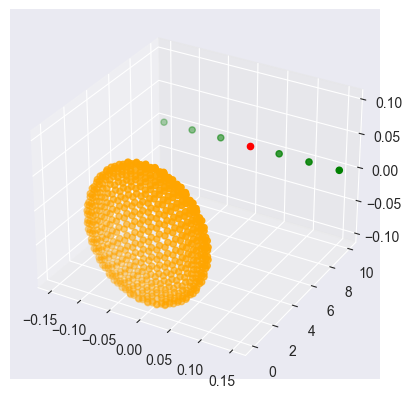

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection= '3d')


# ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='blue')
ax.scatter(sel_centroids[:,0], sel_centroids[:,1], sel_centroids[:,2], c='orange')
# ax.scatter(normals[:,0], normals[:,1], normals[:,2])
ax.scatter(np.array(mic_array)[:,0], np.array(mic_array)[:,1], np.array(mic_array)[:,2], c = 'green')
ax.scatter(source[0], source[1], source[2], c = 'red')
# plt.show()
plt.savefig(f'./graph/{object_name}_illustration.png', dpi=300)
# print("normals:", normals)

In [11]:

#
# # Sonar_simulation with single
wave_power_array , sound_wave_array = create_echo_single_triangles(triangle_edge_distances[fake_position], mics_angles_array, all_distancesTOWARDS_r, all_distances_back_mics, HRTF_omni_array,source_frequancy_vector,parameters)
# print(wave_power, wave_power.shape)

In [12]:
#test adding zeros
#
# N_zeros = 100
# len(wave_power_array[0])+N_zeros
# WP = wave_power_array[0]
# np.real(np.array([np.fft.ifft(np.array(WP.concat(np.zeros(N_zeros))), n=len(wave_power_array[0])+N_zeros)]).T)

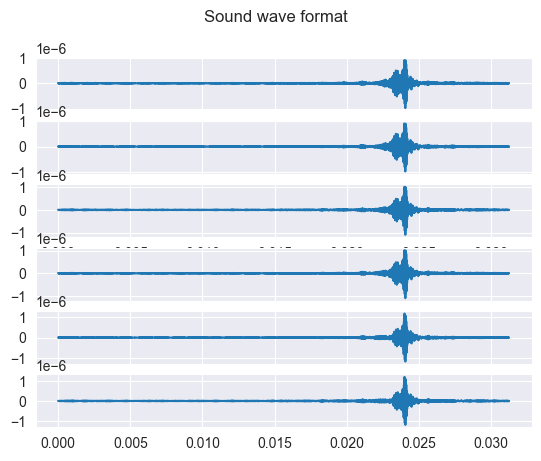

In [13]:

# # plot of the sound wave from both microphone
fig, ax = plt.subplots(len(sound_wave_array))
fig.suptitle('Sound wave format')
for i, sound_wave in enumerate(sound_wave_array):
    Time_axis = np.linspace(0, len(sound_wave) / sample_rate, len(sound_wave))
    ax[i].plot(Time_axis, sound_wave)
# plt.show()
plt.savefig(f'./graph/{object_name}_soundwave.png', dpi=300)


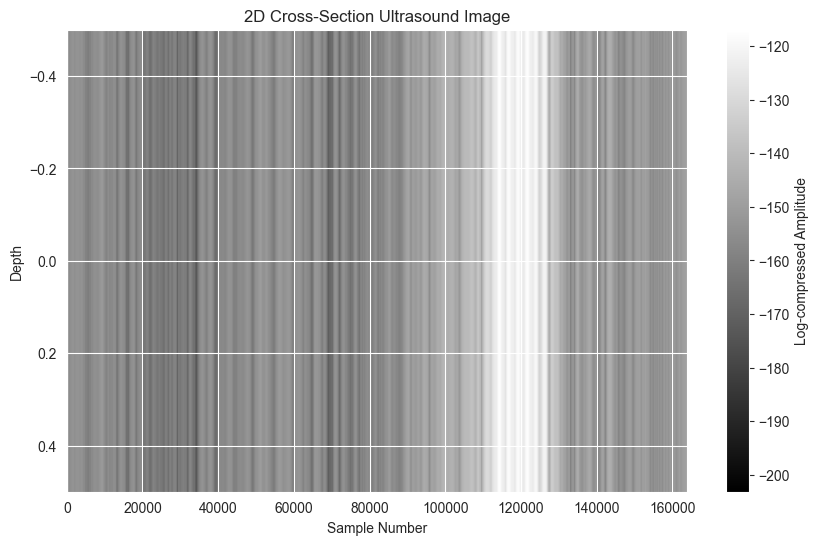

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Simulated raw RF data from phase-array transducer
# For simplicity, we'll use random data. Replace this with actual RF data.
# rf_data = np.random.randn(128, 1024)  # 128 transducer elements, 1024 samples each
rf_data = np.array(sound_wave_array)
rf_data = rf_data.reshape((rf_data.shape[0],rf_data.shape[1]))  # 128 transducer elements, 1024 samples each

# Parameters
sound_speed = 1540  # Speed of sound in tissue (m/s)
# sampling_rate = 40e6  # Sampling rate (Hz)
# sample_rate = fft_size * fft_step_size #2.04MHz Sampling rate (Hz)
focal_depth = 0.5  # Focal depth (meters)
# focal_depth = reciver_to_landscape  # Focal depth (meters)


# Time vector
time_vector = np.arange(rf_data.shape[1]) / sample_rate

# Beamforming (delay-and-sum)
beamformed_data = np.zeros_like(time_vector)
for element in range(rf_data.shape[0]):
    delay = (element * np.sin(np.pi / 4) / sound_speed)  # Adjust angle as needed
    delayed_signal = np.interp(time_vector + delay, time_vector, rf_data[element, :])
    beamformed_data += delayed_signal

# Envelope detection (Hilbert transform)
analytic_signal = hilbert(beamformed_data)
envelope = np.abs(analytic_signal)

# Log compression
log_compressed = 20 * np.log10(envelope + np.finfo(float).eps)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(log_compressed.reshape(1, -1), cmap='gray', aspect='auto')
plt.title('2D Cross-Section Ultrasound Image')
plt.xlabel('Sample Number')
plt.ylabel('Depth')
plt.colorbar(label='Log-compressed Amplitude')
plt.show()

In [61]:
rf_data = np.random.randn(128, 1024)
rf_data.shape
np.array(sound_wave_array).shape
# np.array(sound_wave_array).shape
# sample_rate/1000000
# analytic_signal.shape

(6, 81920, 1)

In [18]:

# # Sonar_simulation with with interval from each echo
# echo_interval = [0, 0.01,0.02,0.03,0.04]
# combined_waves_with_echoes = create_echoes(sound_wave_array, sample_rate, echo_interval)
# # # plot of the sound wave from both microphone
# fig, ax = plt.subplots(len(combined_waves_with_echoes))
# fig.suptitle('Sound wave format')
# for i, ww in enumerate(combined_waves_with_echoes):
#     Time_axis = np.linspace(1 / sample_rate, len(ww) / sample_rate, len(ww))
#     ax[i].plot(Time_axis, ww)
# plt.show()


In [35]:
sample_rate = fft_size * fft_step_size  # Sample rate (multiply in 2)
window_size = 512  # Window size for FFT (2^10)
overlap = 256  # Overlap for FFT (2^8)

In [20]:

# # 2 x = v * t
# # x = v * t / 2
# # Plot sonogram for each receiver
# sns.set_style("whitegrid")
# for i, sound_wave in enumerate(sound_wave_array):
#     plt.figure(figsize=(10, 6))  # Adjust figsize as needed for high resolution
#     flattened_sound_wave = sound_wave.ravel()
#     plt.specgram(flattened_sound_wave, Fs=sample_rate, NFFT=window_size, noverlap=overlap)
#     plt.title(f'Sonogram - Receiver {i + 1}')
#     plt.ylim(0,0.1e6)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.colorbar(label='Intensity (dB)')
#     plt.tight_layout()
#     # Time_axis = np.linspace(0, len(sound_wave_array[i]) / sample_rate, len(sound_wave_array[i]))
#     # plt.plot(Time_axis, sound_wave_array[i])
#     # plt.show()
#     plt.savefig(f'./graph/{object_name}_spectrogram_rec_{i + 1}.png', dpi=300)  # Adjust dpi for high resolution
#     # Save the sonogram as a high-resolution image


C:\Users\meaka\AppData\Local\Temp\ipykernel_7144\2779765506.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f[:len(f)//2], 10 * np.log10(np.abs(Zxx[:len(f)//2])),  shading='gouraud')


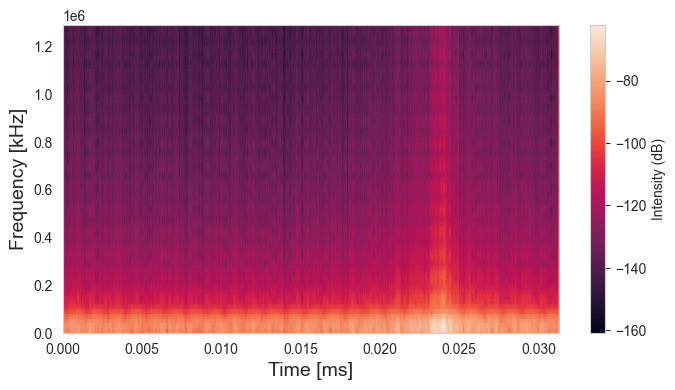

In [33]:
# Testing
flattened_sound_wave = sound_wave.ravel()
f, t, Zxx = signal.stft(flattened_sound_wave, fs=sample_rate, nperseg=200, nfft=256, noverlap=50)
sns.set_style("whitegrid")
fig = plt.figure()
# plt.imshow(x_2[0])
plt.pcolormesh(t, f[:len(f)//2], 10 * np.log10(np.abs(Zxx[:len(f)//2])),  shading='gouraud')
# plt.pcolormesh(t*1000, f[:len(f)//2]/1000, np.abs(Zxx[:len(f)//2]), vmax=1e-8, shading='gouraud')
# plt.ylim(0,100)
plt.colorbar(label='Intensity (dB)')
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.xlabel('Time [ms]', fontsize=14)
fig.set_size_inches((8, 4))
plt.show()

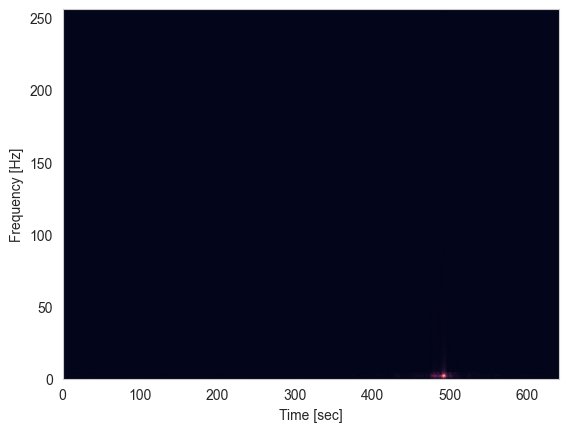

In [36]:
import torch
import matplotlib.pyplot as plt

# Assuming flattened_sound_wave is a 1D numpy array, convert to PyTorch tensor
sound_wave_tensor = torch.tensor(flattened_sound_wave, dtype=torch.float)
spec = torch.stft(sound_wave_tensor, n_fft=window_size, hop_length=overlap, return_complex=True)
spec_magnitude = torch.abs(spec).numpy()

# Plotting
plt.pcolormesh(spec_magnitude, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [37]:
import plotly.graph_objects as go
from scipy import signal

frequencies, times, Sxx = signal.spectrogram(flattened_sound_wave, fs=sample_rate, nperseg=window_size, noverlap=overlap)
fig = go.Figure(data=go.Heatmap(
    z=abs(Sxx[:len(f)//2]),
    x=times*1000,
    y=frequencies[:len(f)//2]/1000,
    colorscale='plasma'
))
fig.update_layout(title='Spectrogram', xaxis=dict(title='Time [sec]'), yaxis=dict(title='Frequency [Hz]'))
fig.show()

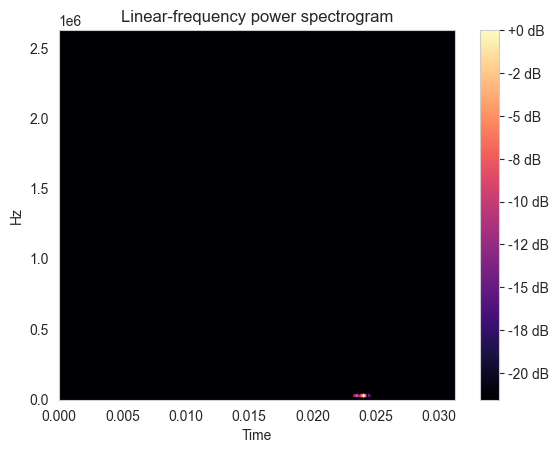

In [38]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
window_size = 512
overlap = 256
D = librosa.stft(flattened_sound_wave, n_fft=window_size, hop_length=overlap)
DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(DB, sr=sample_rate, hop_length=overlap,fmin=10,fmax=1000, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

In [39]:
sample_rate = fft_size * fft_step_size
y=sound_wave_array[6].ravel()
sr=sample_rate
n_fft = 1024
overlap = 512
hop_length = int(librosa.time_to_samples(1./200, sr=sr))
lag = 2
n_mels = 138
fmin = 27.5
fmax = 16000.
max_size = 3
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)

S = librosa.stft(y, n_fft=n_fft, hop_length=overlap)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax, ax=ax)

IndexError: list index out of range

In [29]:
# from scipy import signal
# import seaborn as sns
# sample_rate = fft_size * fft_step_size  # Sample rate (multiply in 2)
# for i, sound_wave in enumerate(sound_wave_array):
#     flattened_sound_wave = sound_wave.ravel()
#     f, t, Zxx = signal.stft(flattened_sound_wave, fs=sample_rate, nperseg=200, nfft=256, noverlap=50)
#     sns.set_style("whitegrid")
#     fig = plt.figure()
#     # plt.imshow(x_2[0])
#     plt.pcolormesh(t*1000, f[:len(f)//2]/1000, np.abs(Zxx[:len(f)//2]),vmax=1e-7,  shading='gouraud')
#     # plt.pcolormesh(t*1000, f[:len(f)//2]/1000, np.abs(Zxx[:len(f)//2]), vmax=1e-8, shading='gouraud')
#     plt.ylim(0,100)
#     plt.colorbar(label='Intensity (dB)')
#     plt.ylabel('Frequency [kHz]', fontsize=14)
#     plt.xlabel('Time [ms]', fontsize=14)
#     fig.set_size_inches((8, 4))
#     plt.grid(False)
#     plt.savefig(f'./graph/{object_name}_stft_rec_{i + 1}.png', dpi=300)


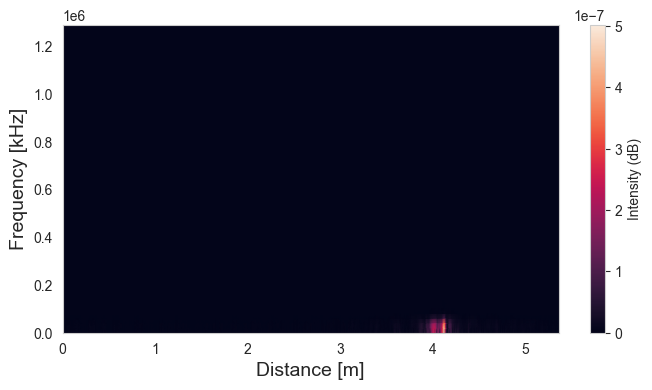

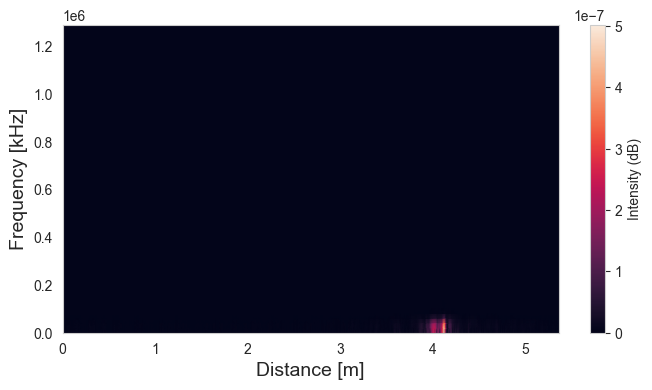

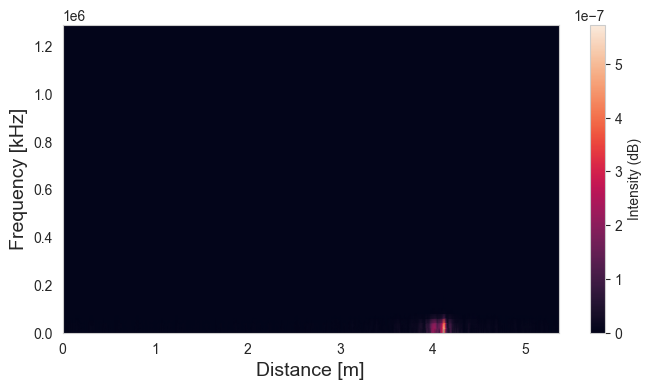

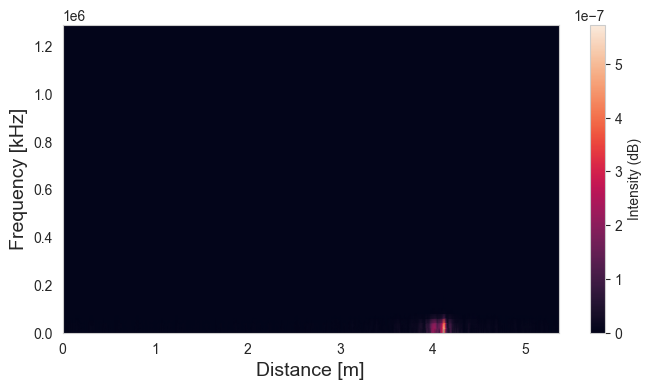

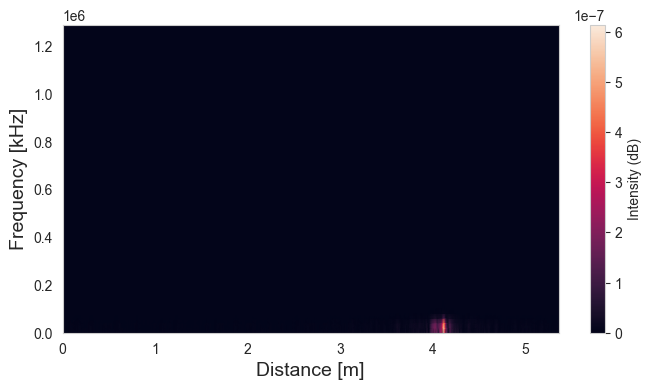

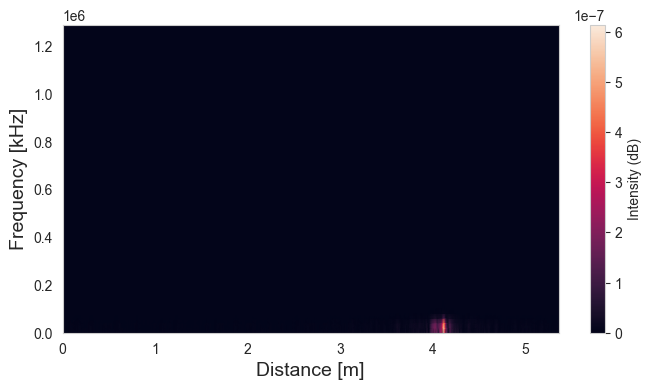

In [40]:
from scipy import signal
import seaborn as sns
sample_rate = fft_size * fft_step_size  # Sample rate (multiply in 2)
for i, sound_wave in enumerate(sound_wave_array):
    flattened_sound_wave = sound_wave.ravel()
    f, t, Zxx = signal.stft(flattened_sound_wave, fs=sample_rate, nperseg=200, nfft=256, noverlap=50)
    sns.set_style("whitegrid")
    fig = plt.figure()
    # plt.imshow(x_2[0])
    distance = (t) * 343 / 2
    plt.pcolormesh(distance, f[:len(f)//2], np.abs(Zxx[:len(f)//2]),  shading='gouraud')
    # plt.pcolormesh(t*1000, f[:len(f)//2]/1000, np.abs(Zxx[:len(f)//2]), vmax=1e-8, shading='gouraud')
    # plt.ylim(0,100)
    plt.colorbar(label='Intensity (dB)')
    plt.ylabel('Frequency [kHz]', fontsize=14)
    plt.xlabel('Distance [m]', fontsize=14)
    fig.set_size_inches((8, 4))
    plt.grid(False)
    plt.savefig(f'./graph/{object_name}_distance_rec_{i + 1}.png', dpi=300)


In [ ]:
wave_power = wave_power_array[1]
np.real(np.array([np.fft.ifft(np.array(wave_power), n=len(wave_power))]).T)


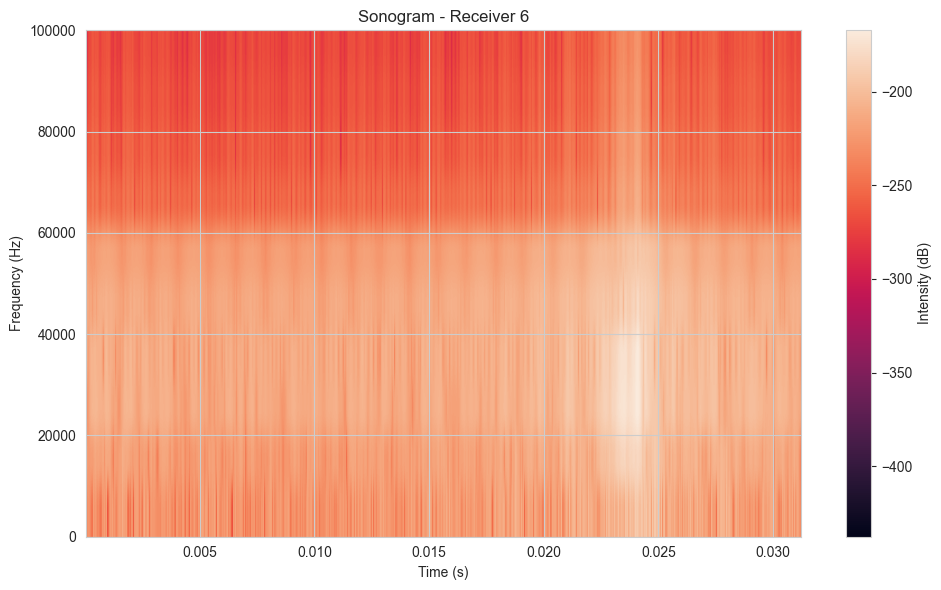

In [41]:
#example plot
sample_rate = fft_size * fft_step_size  # Sample rate (multiply in 2)
window_size = 512  # Window size for FFT (2^10)
overlap = 256  # Overlap for FFT (2^8)
# Plot sonogram for each receiver
sns.set_style("whitegrid")
sound_wave=sound_wave_array[0]
plt.figure(figsize=(10, 6))  # Adjust figsize as needed for high resolution
flattened_sound_wave = sound_wave.ravel()
plt.specgram(flattened_sound_wave, Fs=sample_rate, NFFT=window_size, noverlap=overlap)
plt.title(f'Sonogram - Receiver {i + 1}')
plt.ylim(0,0.1e6)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.tight_layout()



In [42]:
import kapre.time_frequency as kaf
import kapre.composed as kac

import tensorflow as tf

In [43]:
def plot_spectrogram(titles, signals, title, shape=(16, 8)):
    nrows, ncols = 2, 5
    fig, ax = plt.subplots(nrows, ncols, figsize=shape)
    fig.suptitle(title, size=20)
    plt.set_cmap('viridis')

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i, y].set_title(titles[z])
            ax[i, y].imshow(signals[z].squeeze())
            ax[i, y].set_xticks([])
            ax[i, y].set_yticks([])
            ax[i, y].grid(False)
            z += 1

    plt.show()


In [42]:
def plot_signals_time(titles, signals):

    nrows, ncols = 2, 5
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 6))

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i,y].set_title(titles[z])
            ax[i,y].plot(signals[z])
            ax[i,y].set_xticks([])
            ax[i,y].set_yticks([])
            ax[i,y].grid(False)
            z += 1

    plt.show()

In [43]:
sound_wave=sound_wave_array[0]
# Ensure the audio is mono
audio_tensor = tf.squeeze(sound_wave, axis=-1)

# Define the spectrogram using Kapre
spectrogram_layer = kac.get_stft_magnitude_layer(n_fft=1024, win_length=1024, hop_length=512,
                                pad_end=True)

# Compute the spectrogram
spectrogram = spectrogram_layer(audio_tensor[tf.newaxis, :, tf.newaxis])

NameError: name 'tf' is not defined

In [44]:
audio_tensor[tf.newaxis, :, tf.newaxis]

NameError: name 'audio_tensor' is not defined

In [45]:
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0, :, :].numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.title('Spectrogram')
plt.ylabel('Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()

NameError: name 'spectrogram' is not defined

<Figure size 1000x400 with 0 Axes>

In [46]:
audio_tensor = tf.convert_to_tensor(sound_wave, dtype=tf.float32)
audio_tensor = tf.squeeze(audio_tensor, axis=-1)
# audio_tensor, sample_rate = tf.audio.decode_wav(sound_tensor)
# audio_tensor = tf.squeeze(audio_tensor, axis=-1)

# Define the spectrogram layer
spectrogram_layer = kac.get_stft_magnitude_layer(input_shape=(None,),
                                             n_fft=1024,
                                             win_length=1024,
                                             hop_length=512,
                                             return_decibel=True)

# Apply the layer to your audio tensor
spectrogram = spectrogram_layer(audio_tensor[None, :, None])

# Plot the spectrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(tf.math.log(spectrogram[0, :, :, 0]).numpy().T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Spectrogram')
plt.ylabel('Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()

NameError: name 'tf' is not defined

In [47]:
sound_tensor = tf.convert_to_tensor(sound_wave, dtype=tf.float32)
sound_tensor = tf.squeeze(sound_tensor, axis=-1)

NameError: name 'tf' is not defined

In [48]:
sound_wave

array([[3.76268799e-09],
       [3.59632182e-09],
       [3.42055256e-09],
       ...,
       [4.20218017e-09],
       [4.06591276e-09],
       [3.91932077e-09]])

In [49]:
tf.convert_to_tensor(sound_wave, dtype=tf.float32)

NameError: name 'tf' is not defined

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from kapre.time_frequency import STFT, Magnitude
import matplotlib.pyplot as plt

# Define the input shape
input_shape = (None, 1)

# Create the model
model = tf.keras.models.Sequential([
    Input(shape=input_shape),
    STFT(n_fft=2048, hop_length=1024, win_length=2048),
    Magnitude(),
    tf.keras.layers.Lambda(lambda x: tf.math.log(x + 1e-6))  # Convert to log scale
])

# Assuming sound_wave is your numpy array shaped (81920, 1)
sound_tensor = tf.convert_to_tensor(sound_wave, dtype=tf.float32)
sound_tensor = tf.squeeze(sound_tensor, axis=-1)

# Apply the model
spectrogram = model(sound_tensor[None, :, None])

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0, :, :].numpy().T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Spectrogram')
plt.ylabel('Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()


RuntimeError: Exception encountered when calling STFT.call().

[1mCould not automatically infer the output shape / dtype of 'stft_2' (of type STFT). Either the `STFT.call()` method is incorrect, or you need to implement the `STFT.compute_output_spec() / compute_output_shape()` method. Error encountered:

Invalid dtype: complex64[0m

Arguments received by STFT.call():
  • args=('<KerasTensor shape=(None, None, 1), dtype=float32, sparse=None, name=keras_tensor_2>',)
  • kwargs=<class 'inspect._empty'>